In [1]:
from time import time

In [2]:
from numpy import expand_dims, clip, squeeze, arange

In [3]:
from PIL.Image import fromarray

In [4]:
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.optimizers import Adam

In [6]:
class NeuralStyleTransfer(object):

    def __init__(self, content_img, style_img):
        self.content_img = self.load_and_process_image(content_img)
        self.style_img = self.load_and_process_image(style_img)
        self.generated_images = []
        self.best_image = None
        self.best_cost = 1e14+0.1
        self.is_training = False
        self.initialize_models_and_layers()
        self.set_paramers_and_hyper_parameters()
        self.generated = None

    def set_paramers_and_hyper_parameters(self, iterations=2, alpha=10., beta=20., lr=0.01):
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.lam = 1. / len(self.style_models)

    def initialize_models_and_layers(self):
        self.model = VGG19(include_top=False, weights='imagenet')
        self.model.trainable = False
        self.style_layers = ['block1_conv1','block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']
        self.content_layer = 'block5_conv2'
        self.content_model = Model(inputs=self.model.input,
                                   outputs=self.model.get_layer(self.content_layer).output)
        self.style_models = [Model(inputs=self.model.input,
                                   outputs=self.model.get_layer(layer).output) for layer in self.style_layers]

    def load_and_process_image(self, image_path):
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img)
        img = preprocess_input(img)
        img = expand_dims(img, axis=0)
        return img

    def get_model_layers(self):
        self.layers = []
        for layer in self.model.layers:
            self.layers.append(layer.name)
        return self.layers
        
    def deprocess(self, x):
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = clip(x, 0, 255).astype('uint8')
        return x

    def save_image(self, image):
        if len(image.shape) == 4:
            img = squeeze(image, axis=0)
        img = self.deprocess(img)
        im = fromarray(img)
        filename = "final" + str(int(time())) + ".png"
        im.save('./static/'+filename)
        return filename

    def content_cost(self, content, generated):
        a_C = self.content_model(content)
        a_G = self.content_model(generated)
        cost = tf.reduce_mean(tf.square(a_C - a_G))
        return cost

    def calculate_gram_matrix(self, A):
        channels = int(A.shape[-1])
        a = tf.reshape(A, [-1, channels])
        n = tf.shape(a)[0]
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(n, tf.float32)

    def style_cost(self, style, generated):
        J_style = 0
        for style_model in self.style_models:
            a_S = style_model(style)
            a_G = style_model(generated)
            GS = self.calculate_gram_matrix(a_S)
            GG = self.calculate_gram_matrix(a_G)
            current_cost = tf.reduce_mean(tf.square(GS - GG))
            J_style += current_cost * self.lam
        return J_style

    def train(self):
        self.generated = tf.Variable(self.content_img, dtype=tf.float32)
        self.is_training = True
        self.best_image = self.generated.numpy()
        for i in range(self.iterations):
            with tf.GradientTape() as tape:
                J_content = self.content_cost(self.content_img, self.generated)
                J_style = self.style_cost(self.style_img, self.generated)
                J_total = self.alpha * J_content + self.beta * J_style
            grads = tape.gradient(J_total, self.generated)
            self.optimizer.apply_gradients([(grads, self.generated)])
            print(f"J_total: {J_total}")
            if J_total < self.best_cost:
                self.best_cost = J_total
                self.best_image = self.generated.numpy()
            self.generated_images.append(self.generated.numpy())
            yield J_total, self.is_training
        self.is_training = False
        yield self.best_image, self.is_training
        
    def continue_training(self, additional_iterations=10):
        self.is_training = True
        for i in range(additional_iterations):
            with tf.GradientTape() as tape:
                J_content = self.content_cost(self.content_img, self.generated)
                J_style = self.style_cost(self.style_img, self.generated)
                J_total = self.alpha * J_content + self.beta * J_style
            grads = tape.gradient(J_total, self.generated)
            self.optimizer.apply_gradients([(grads, self.generated)])
            print(f"J_total: {J_total}")
            if J_total < self.best_cost:
                self.best_cost = J_total
                self.best_image = self.generated.numpy()
            self.generated_images.append(self.generated.numpy())
            yield J_total, self.is_training
        self.is_training = False
        yield self.best_image, self.is_training
        

In [7]:
nst = NeuralStyleTransfer(content_img="/home/romil/Desktop/Projects/artistify/static/content.jpg", style_img="/home/romil/Desktop/Projects/artistify/static/style.jpg")

In [8]:
nst.get_model_layers()

['input_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [9]:
iterations = 2
cost = []

In [10]:
nst.set_paramers_and_hyper_parameters(iterations, alpha=10., beta=20., lr=3.14)

In [11]:
for val, is_training in nst.train():
    if is_training: cost.append(val.numpy())

J_total: 1084559458304.0
J_total: 747710119936.0


In [12]:
for val, is_training in nst.continue_training(additional_iterations=13):
    if is_training: cost.append(val.numpy())
    else:
        fname = nst.save_image(val)
        print(fname)

J_total: 503391191040.0
J_total: 359582957568.0
J_total: 296360968192.0
J_total: 259988357120.0
J_total: 226989359104.0
J_total: 202669211648.0
J_total: 185146884096.0
J_total: 168367931392.0
J_total: 151773298688.0
J_total: 137609822208.0
J_total: 126075682816.0
J_total: 115944603648.0
J_total: 107074281472.0
final1601618859.png


/home/romil/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


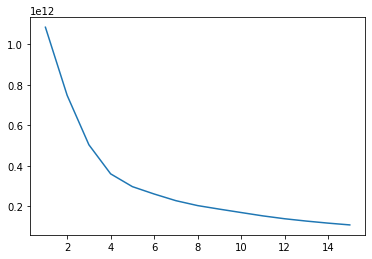

In [13]:
sns.lineplot(arange(1,len(cost)+1),cost);